In [1]:
import numpy as np

import datasets
import utils

from ela import generator, random

predictions = utils.TestPredictions('nopoolrefinenet_50_128_lovasz_elu_focal_finetune', mode='val').load_raw()
samples = utils.get_train_samples()
transforms = generator.TransformationsGenerator([])
dataset = datasets.AnalysisDataset(samples, './data/train', transforms, predictions)

In [2]:
import torch
from tqdm import tqdm
from metrics import mAP

data = {}


for i in tqdm(range(len(dataset))):   
    prediction, target, id = dataset[i]
    
    prediction_tensor = torch.FloatTensor(prediction).unsqueeze(0).unsqueeze(0)
    target_tensor = torch.FloatTensor(target).unsqueeze(0).unsqueeze(0)
    
    score = mAP(prediction_tensor > 0.5, target_tensor).item()
    
    data[id] = (prediction, target, score)


100%|██████████| 4000/4000 [03:53<00:00, 17.14it/s]


In [3]:
mean_score = []
for id, (prediction, target, score) in data.items():  
    mean_score.append(score)
    
print(np.mean(np.array(mean_score)))

0.85309999878


In [4]:
mean_score = []
for i in tqdm(range(len(dataset))):   
    prediction, target, id = dataset[i]
    
    prediction_tensor = torch.FloatTensor(prediction).unsqueeze(0).unsqueeze(0)
    target_tensor = torch.FloatTensor(target).unsqueeze(0).unsqueeze(0)
    
    score = mAP(prediction_tensor > 0.5, target_tensor).item()
    mean_score.append(score)
    
print(np.mean(np.array(mean_score)))

100%|██████████| 4000/4000 [03:49<00:00, 17.43it/s]

0.85309999878


In [5]:

buckets_area = {
    0.001: [],
    0.10: [],
    0.15: [],
    0.20: [],
    0.25: [],
    0.5: [],
    0.75: [],
    1.00: [],
}

for id, (prediction, target, score) in data.items():
    prediction_tensor = torch.FloatTensor(prediction).unsqueeze(0).unsqueeze(0)
    target_tensor = torch.FloatTensor(target).unsqueeze(0).unsqueeze(0)

    for key in buckets_area:
        if target_tensor.sum() / (101*101) <= key:
            buckets_area[key].append((id, prediction, target, score))
            break

In [6]:
mean_overall = []
gain_overall = []

for key, value in buckets_area.items():
    mean_score = []
    for id, prediction, target, score in value:
        mean_score.append(score)
        
    mean = np.mean(np.array(mean_score))
    ratio = len(mean_score) / 4000
    gain = ratio * (1 - mean)
    print('{:0.2f}: {:0.3f} - ratio: {:0.3f}, gain: {:0.3f}'.format(key, mean, ratio, gain))
    
    mean_overall.append(ratio*mean)
    gain_overall.append(gain)
    
mean_overall = np.sum(np.array(mean_overall))
gain_overall = np.sum(np.array(gain_overall))
sum_overall = gain_overall + mean_overall
print('Mean overall: {:0.3f}, gain overall: {:0.3f}, sum {:0.3f}'.format(mean_overall, gain_overall, sum_overall))


0.00: 0.941 - ratio: 0.402, gain: 0.024
0.10: 0.496 - ratio: 0.133, gain: 0.067
0.15: 0.720 - ratio: 0.043, gain: 0.012
0.20: 0.803 - ratio: 0.031, gain: 0.006
0.25: 0.884 - ratio: 0.026, gain: 0.003
0.50: 0.904 - ratio: 0.133, gain: 0.013
0.75: 0.906 - ratio: 0.114, gain: 0.011
1.00: 0.903 - ratio: 0.119, gain: 0.012
Mean overall: 0.853, gain overall: 0.147, sum 1.000


In [7]:
sorted_by_median = []
for id, (prediction, target, score) in data.items():
    sorted_by_median.append((id, prediction, target, score))
    
    
def sort_median(item):
    return np.abs(np.median(item[1]) - 0.5)
    
sorted_by_median = sorted(sorted_by_median, key=sort_median)

In [8]:
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from skimage import img_as_float
from skimage.io import imread

rows = 100
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
for i, (id, prediction, target, score) in zip(range(rows), buckets_area[0.10]):
    im = ax[i][0].imshow(prediction, vmin = 0, vmax = 1)
    ax[i][0].set_title('{}:, {}: {:6.4f}'.format(i, id, score))
    ax[i][1].imshow(prediction > 0.5)
    ax[i][1].set_title('thresholded {}'.format(id))
    ax[i][2].imshow(np.abs(target - (prediction > 0.5)))
    ax[i][2].set_title('diff {}'.format(id))
    ax[i][3].imshow(target)
    ax[i][3].set_title('mask {}'.format(id))
    overlay = np.repeat(np.expand_dims(0.5*target, axis=2), 3, axis=2)
    overlay[:, :, [0, 1]] = 0
    ax[i][4].imshow(np.clip(overlay + img_as_float(imread(join('./data/train', 'images', id) + '.png')), 0, 1))
    ax[i][4].set_title('image {}'.format(id))    
    fig.colorbar(im, orientation='vertical', ax=ax[i][0])
    ax[i][5].imshow(img_as_float(imread(join('./data/train', 'images', id) + '.png')))
    ax[i][5].set_title('image {}'.format(id))    
    
plt.tight_layout()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


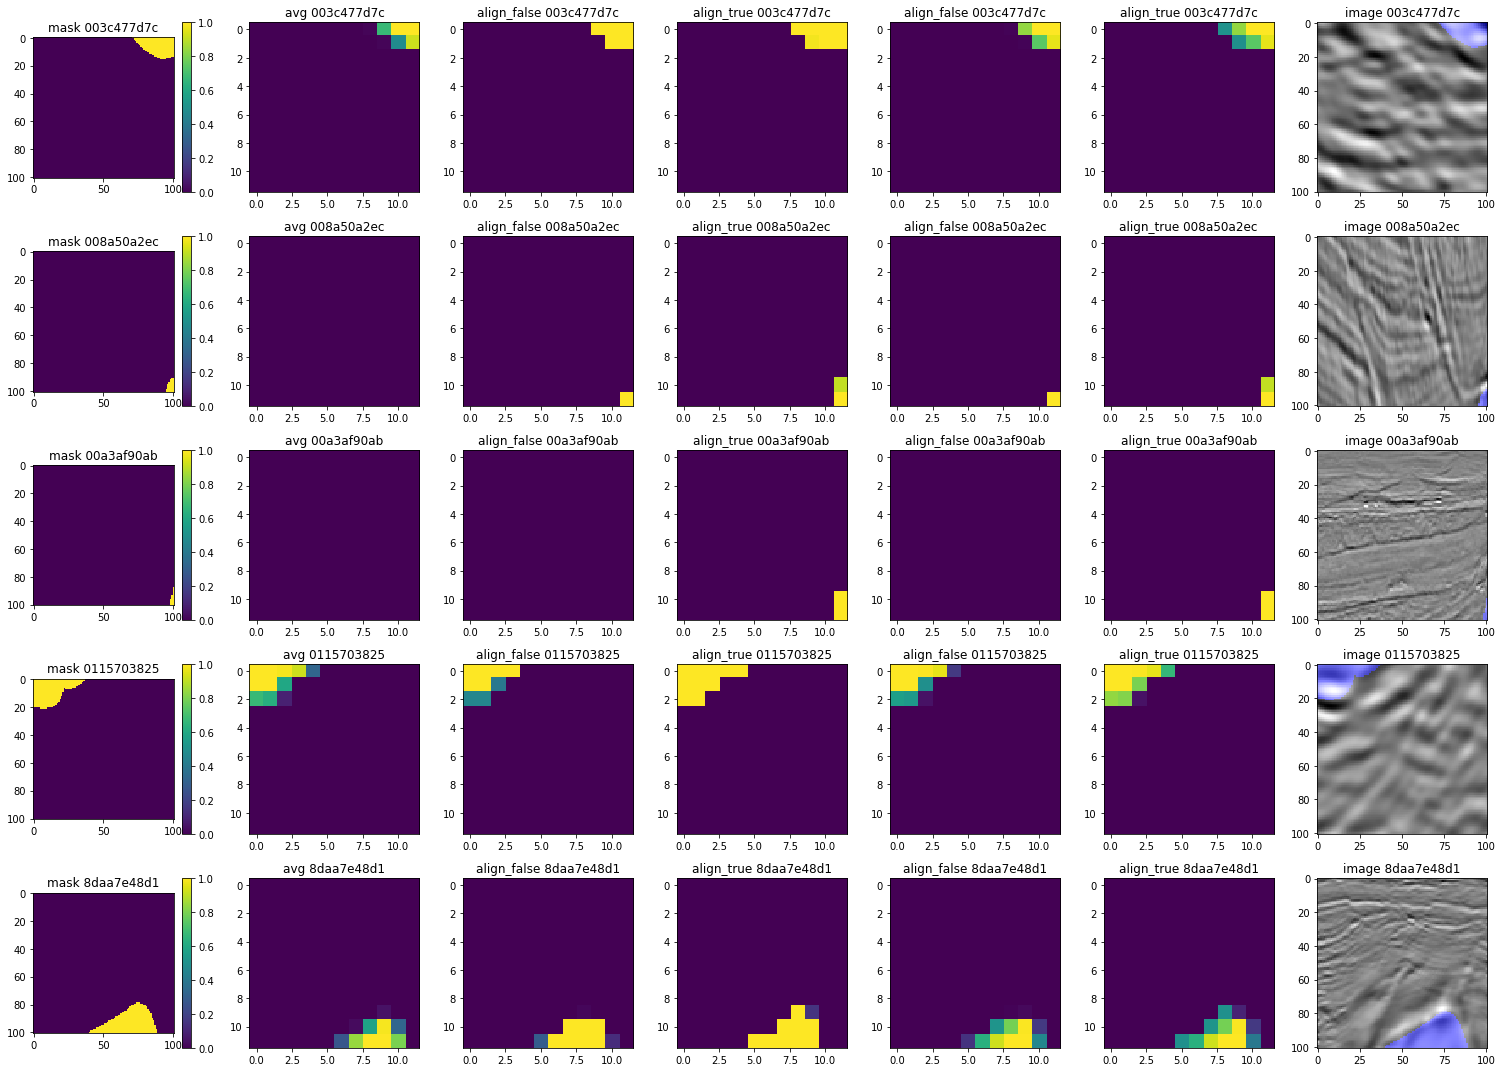

In [9]:
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from torch.nn import functional as F

from skimage import img_as_float
from skimage.io import imread

rows = 5
cols = 7
fig, ax = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
for i, (id, prediction, target, score) in zip(range(rows), buckets_area[0.1]):
    im = ax[i][0].imshow(prediction, vmin = 0, vmax = 1)
    ax[i][0].imshow(target)
    ax[i][0].set_title('mask {}'.format(id))
    
    target_t = torch.from_numpy(target)
    target_t_pooled = F.avg_pool2d(target_t.unsqueeze(0).unsqueeze(0), 8).squeeze()
    target_pooled_avg = target_t_pooled.numpy()
    ax[i][1].imshow(target_pooled_avg)
    ax[i][1].set_title('avg {}'.format(id))
    
    target_t = torch.from_numpy(target)
    target_t_pooled = F.interpolate(target_t.unsqueeze(0).unsqueeze(0), scale_factor=1/8, mode='bilinear', align_corners=False).squeeze()
    target_pooled_align_false = target_t_pooled.numpy()    
    ax[i][2].imshow(target_pooled_align_false)
    ax[i][2].set_title('align_false {}'.format(id))
    
    
    target_t = torch.from_numpy(target)
    target_t_pooled = F.interpolate(target_t.unsqueeze(0).unsqueeze(0), scale_factor=1/8, mode='bilinear', align_corners=True).squeeze()
    target_pooled_align_true = target_t_pooled.numpy()    
    ax[i][3].imshow(target_pooled_align_true)
    ax[i][3].set_title('align_true {}'.format(id))
    
    ax[i][4].imshow((target_pooled_align_false + target_pooled_avg) / 0.5)
    ax[i][4].set_title('align_false {}'.format(id))
    
    ax[i][5].imshow((target_pooled_align_true + target_pooled_avg) / 0.5)
    ax[i][5].set_title('align_true {}'.format(id))
    
    overlay = np.repeat(np.expand_dims(0.5*target, axis=2), 3, axis=2)
    overlay[:, :, [0, 1]] = 0
    ax[i][6].imshow(np.clip(overlay + img_as_float(imread(join('./data/train', 'images', id) + '.png')), 0, 1))
    ax[i][6].set_title('image {}'.format(id))    
    fig.colorbar(im, orientation='vertical', ax=ax[i][0])
    
plt.tight_layout()